In [1]:
function extract_J(V,W)

    coshu = sqrt(V*V');
    exp_phi = inv(coshu) * V;

    F, coshr, X = svd(coshu);

    nel = length(coshr);
    print(nel)
    r = zeros(nel);

    for i in 1:nel
        if abs(coshr[i]  - 1.0) < 1.0e-4
            coshr[i] = 1.0;
            #print("== $(coshr[i])");
        end
        r[i] = acosh(coshr[i]);
    end

    #check that X=F
    Fcheck = sum(sum(F - X));

    if abs(Fcheck)>1.0e-10
        println("F neq X");
        print(Fcheck)
    end

    sinhr = sinh.(r);

    Kinv_eig = zeros(nel);
    K_eig = zeros(nel);

    for i in 1:nel
        if r[i] < 1e-12
            Kinv_eig[i] = 1.0;
            K_eig[i] = 1.0;
        else
            Kinv_eig[i] = r[i]/sinhr[i];
            K_eig[i] = sinhr[i]/r[i];
        end
    end

    Kinv = F*diagm(Kinv_eig)*F';
    K = F*diagm(K_eig)*F';

    J = Kinv*(W*transpose(exp_phi));

    return J, exp_phi, r;

end

function nonlinear_coeff(t)

    Lambda = zeros(Complex{Float64}, n,n,n);
    FS1_amp = sqrt(2.0*eta*vg/(2.0*pi*R*GammaS));
    FS2_amp = sqrt(2.0*eta*vg/(2.0*pi*R*GammaS));
    FP_amp = sqrt(2.0*eta*vg/(2.0*pi*R*GammaP));

    AC = sqrt( 2.0*pi*PC/(hbar * wC * vg) ) * sqrt(2*eta*vg/GammaC) * 1im;

    mfact = -(2.0*pi/L)^(1.5)*(1/(4.0*pi^2))*hbar*vg^2*gamma_nl*omegaS*sqrt(2.0*pi*R)*FS1_amp*FS2_amp*FP_amp*AC;

    for idx1 in 1:n
        arg1 = x[idx1];
    
        for idx2 in 1:n
             arg2 = x[idx2];

            for idx3 in 1:n
                arg3 = x[idx3];
        
                Lambda[idx1,idx2,idx3] = 1/(-arg1 - 1im) * 1/(-arg2-1im)* 1/(-arg3-1im)  * exp(-1im*(arg3 - arg1 - arg2)*t);
             
            end
        end
    end
    
    return mfact*Lambda;

end

function solve_ode(u0, tspan)

    function ode!(du,u,p,t)

        V_vec = u[1:n*n];
        W_vec = u[n*n+1:2*n*n];
        beta = u[2*n*n+1:n*(2*n+1)];

        V = reshape(V_vec,n,n);
        W = reshape(W_vec, n,n);

        spdc = nonlinear_coeff(t);

        #build the Zeta matrix from spdc
        Zeta = zeros(Complex{Float64}, n,n);
        for idx2 in 1:n
            for idx3 in 1:n

                Zeta[idx2, idx3] = transpose(spdc[idx2, idx3, :])*beta;

            end
        end

        #build the gammadis matrix from spdc, V, and W
        gammadis = zeros(Complex{Float64}, n);
        for idx2 in 1:n
            
            gammadis[idx2] = sum(conj(spdc[:,:,idx2]).*(V*transpose(W)));
     
        end

    
        dbeta = -1im*gammadis / GammaC;    
        dV = -2.0*1im * Zeta * conj(W) / GammaC;
        dW = -2.0*1im * Zeta * conj(V) / GammaC;
    
        du[1:n*n] .= dV[:];
        du[n*n+1:2*n*n] .= dW[:];
        du[2*n*n+1:n*(2*n+1)] .= dbeta;
    end

    prob = ODEProblem(ode!, u0, tspan);
    sol = solve(prob,Tsit5());
  
    return sol;
end

function nph_tot(u)
    #this function calcualtes the total photon number from the solution (sol) at each time
    #and returns a vector with the same length as the time vector
    Nt = length(tode);
    nphS = zeros(Nt);
    nphP = zeros(Nt);

    for idx1 in 1:Nt
        u_now = u[idx1];
        V_now = reshape(u_now[1:n*n],n,n);
        W_now = reshape(u_now[n*n+1:2*n*n],n,n);
        beta_now = u_now[2*n*n+1:n*(2*n+1)];

        nphS[idx1] = (tr(W_now'*W_now));
        nphP[idx1] = beta_now'*beta_now;
    end

    return nphS, nphP;

end

nph_tot (generic function with 1 method)

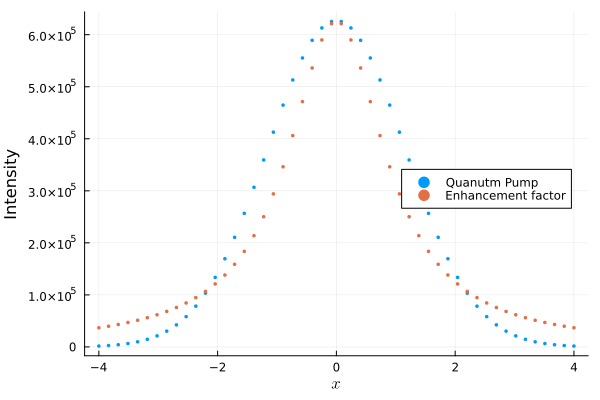

Number of k modes = 50 
Classical pump power = 80.0 mW
Quantum pump duration = 1.0 ns
Loaded Q = 1.0e6


[ Info:  started timer at: 2024-02-29T12:49:11.673
[ Info:          85.23885125s: 1 minute, 25 seconds, 238 milliseconds


50

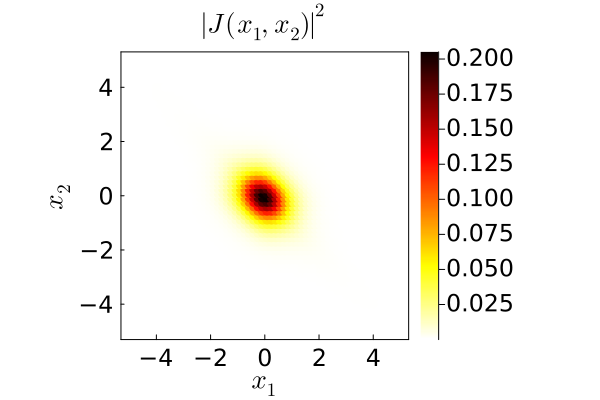

7.75836261135055e6942.68223713262337.758833952469117e6Number of generated photons = 942.6822371326233
Schmidt number = 1.001236838444191
Final number of quantum pump photons = 7.75836261135055e6
Pump depletion ratio = 0.006074813681855584%
Conversion efficiency = 0.01214979265810594%
Initial total photon number = 7.7588339460566575e6
Final total photon number = 7.758833952469117e6
Total photon number conserved?  percent. diff = 8.264720677513787e-8%


In [2]:
using DifferentialEquations
using LinearAlgebra
using Plots 
using TickTock
using Trapz
using LaTeXStrings

c = 299792458;
hbar = 1.05457182e-34;
gamma_nl = 1.0; #nonlinear parameter for SiN units of (Wm)^-1
eta = 1.0; #0.9 coupling efficiency to the real channel
Q = 1.0e6; #loaded quality factor
R = 45.0e-6; #ring radius
neff = 1.8; #effective index for SiN around 1550 nm
ng = 2.1; #group index for SiN around 1550 nm
vg = c/ng; #group velocity
fsr = vg/(2*pi*R); #free spectral range
TR = 2*pi*R*neff/c; #ring round trip time
lambdaS = 1550.0e-9; #wavelength for squeezed light
fS = c/lambdaS; #frequency of squeezed light
fC = fS - fsr; #frequency of classical pump C
fP = fS + fsr; #frequency of quantum pump P
wP = 2*pi*fP; # angular frequency of quantum pump P
wC = 2*pi*fC; # angular frequency of classical pump C
lambdaP = c/fP; #wavelength of quantum pump P
lambdaC = c/fC; #wavelength of classical pump C
PC = 80.0e-3 #80.0e-3; #power of classical pump C
tauP = 1.0e-9 #6.0e-9; #duration of quantum pump P
UP = 1e-12 #3.0e-12; #energy of quantum pump P

omegaS = 2*pi*fS; #angular frequency of squeezed light
GammaS = omegaS/(2*Q); #decay rate for squeezed light
GammaC = wC/(2*Q); #decay rate for classical pump C
GammaP = wP/(2*Q); #decay rate for quantum pump P

#define a dimensionless parameter x = vg(k - K)/Gamma, where K is the center k of the resonance
x_min = -4.0;
x_max = 4.0;
n = 50; #number of k - modes
x = collect(range(x_min, x_max, length=n)); #dimensionless parameter
dx = x[2]-x[1];#spacing between x's. I have made them all the same for the three different frequencies
dk = GammaS/vg * dx; #spacing between k's
L = 2*pi/dk; #normalization length in channel


#plot the initial quantum pump pulse and field enhancement factor in k space
pulse = sqrt(UP/(hbar*wP))*sqrt(vg*tauP/sqrt(pi)) * exp.(-0.5*GammaP^2*tauP^2*x.^2);
Fenh = maximum(pulse.^2)*( x.^2 .+ 1.0).^(-1);

p1 =scatter(x, [pulse.^2, Fenh], markerstrokewidth=0, ms = 2, xlabel=L"x", ylabel = "Intensity", labels=["Quanutm Pump" "Enhancement factor"], legend=:right)

#set up time array
tbar_min = 0.0; #very early time  when there is no nonlinear interaction
tbar_max = 10.0; #very late time when there is no nonlinear interaction

#display the plot
display(p1);

#initial matrices for V and W and beta at t = 0
V0 = Matrix{Float64}(I,n,n).+0.0im;
W0 = zeros(n,n);
NP = round(Int, n/2); #index for the peak of pump P
beta0 = sqrt(UP/(hbar*wP))*sqrt(2.0*pi/L)*sqrt(vg*tauP/sqrt(pi)) * exp.(-0.5*GammaP^2*tauP^2*(x.- x[NP]).^2);

u0 = [V0[:]; W0[:]; beta0];
tspan = (tbar_min, tbar_max);



################################################

println("Number of k modes = $n ")
println("Classical pump power = $(PC*1e3) mW")
println("Quantum pump duration = $(1e9*tauP) ns")
println("Loaded Q = $Q")

################################################

#solve the ODEs for V and W. Also measure how long it takes. 

tick()
sol = solve_ode(u0, tspan);
tock()

#unpack the solution
tode = sol.t;
u = sol.u;

u1 = u[end];
V1 = reshape(u1[1:n*n],n,n);
W1 = reshape(u1[n*n+1:2*n*n],n,n);
beta1 = u1[2*n*n+1:n*(2*n+1)];

#check that the two contraints are satisfied
check1 = V1*V1' - W1*W1';
check2 = V1*transpose(W1) - W1*transpose(V1);

#extract the parameters of the squeezed state
J, exp_phi, r = extract_J(V1, W1);

nphP= real(beta1'*beta1)
nphS= real(tr(W1'*W1))
ntot = 0.5*nphS + nphP  


#do a plot of the total photon number vs time to see if its conserved
#p2 =scatter(tode, 0.5*nphS .+ nphP, markerstrokewidth=0, ms = 2, xlabel=L"t", ylabel = "Total photon number");

#display(p2);


#Schmidt number at the final time
K=(real(nphS))^2/sum(sinh.(r).^4);

#do a scatter plot of the squeezing matrix J at the final time
# versus the dimensionless parameters x1 and x2.
XX = repeat(x, outer = [1,n]);

p3 =  scatter(XX,XX', marker_z = (abs.(J)).^2,
legend = false, 
colorbar=true,
msw = 0, 
ms = (19*13/8*dx), 
color = cgrad(:hot, rev=true),
aspect_ratio=:equal, 
xlabel=L"x_1", 
ylabel=L"x_2", 
titlefontsize = 18, 
guidefontsize=18, 
tickfontsize = 16,
right_margin = 20Plots.mm,
top_margin = 4Plots.mm,
framestyle = :box, 
grid=false,
title=L"|J(x_1,x_2)|^2",
xticks = x_min:2:x_max,
yticks = x_min:2:x_max,
xlimits = (x_min-8*dx,x_max+8*dx),
ylimits = (x_min-8*dx,x_max+8*dx)
)

p4 = scatter(x, [abs.(beta0).^2, abs.(beta1).^2], markerstrokewidth=0,ms = 1, xlabel=L"x", ylabel = "Intensity",labels=["Initial" "Final"], legend=:right)

display(p3);

#calculate quantum pump depletetion
nph0 = real(beta0'*beta0); #initial photon number in quantum pump equal to UP/(hbar * wp)
nph1= real(beta1'*beta1); #final photon number in quantum pump 
ratio = 1.0 - nph1/nph0;

nph_initial = nph0; # initial total photon number
nph_final = nph1 + 0.5*nphS; # final total photon number
  

print(nphP, nphS, ntot)

################################################
println("Number of generated photons = $(nphS[end])")
println("Schmidt number = $K")
println("Final number of quantum pump photons = $nph1")
println("Pump depletion ratio = $(100*ratio)%")
println("Conversion efficiency = $(100*nphS[end]/nph0)%")
println("Initial total photon number = $nph_initial")
println("Final total photon number = $nph_final")
println("Total photon number conserved?  percent. diff = $(200*abs(nph_final - nph_initial)/(nph_final+nph_initial))%")
################################################

In [3]:
#different durations (1-10 ns)
#different energies (1 - 8 pJ)
#build loop over these parameters, build nph matrix like J and do scatter plot with colors 